In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import numpy as np
import tensorflow as tf

import wf_psf as wf

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field


%pylab inline 


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.colormaps['Oranges_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels


# Load model

In [11]:
!ls ./../../papers/article_IOP/data/models

wavediff-graph	wavediff-original  wavediff-polygraph  zernike_15  zernike_40


In [12]:

# Model arguments
# (replaces the cli parameters)

args = {
    'dataset_folder': './../../data/coherent_euclid_dataset/',
    'train_dataset_file': 'train_Euclid_res_200_TrainStars_id_001.npy',
    'test_dataset_file': 'test_Euclid_res_id_001.npy',
    'weights_paths': './../../papers/article_IOP/data/models/wavediff-original/chkp_callback_poly_sample_w_bis1_2k_cycle2',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
}


n_bins_lda = 20

# saving_dir = './../figures/'
saving_dir = './'


In [13]:

# Define model run id
# run_id_name = args['model'] + args['id_name']


## Check GPU and tensorflow version
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
print('tf_version: ' + str(tf.__version__))



## Load datasets
train_dataset = np.load(args['dataset_folder'] + args['train_dataset_file'], allow_pickle=True)[()]
# train_stars = train_dataset['stars']
noisy_train_stars = train_dataset['noisy_stars']
# train_pos = train_dataset['positions']
train_SEDs = train_dataset['SEDs']
# train_zernike_coef = train_dataset['zernike_coef']
train_C_poly = train_dataset['C_poly']
train_parameters = train_dataset['parameters']

test_dataset = np.load(args['dataset_folder'] + args['test_dataset_file'], allow_pickle=True)[()]
test_stars = test_dataset['stars']
test_pos = test_dataset['positions']
test_SEDs = test_dataset['SEDs']
# test_zernike_coef = test_dataset['zernike_coef']

# Convert to tensor
tf_noisy_train_stars = tf.convert_to_tensor(train_dataset['noisy_stars'], dtype=tf.float32)
tf_train_pos = tf.convert_to_tensor(train_dataset['positions'], dtype=tf.float32)
tf_test_pos = tf.convert_to_tensor(test_dataset['positions'], dtype=tf.float32)

print('Dataset parameters:')
print(train_parameters)


## Prepare models
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter'])
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))

for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

# Outputs (needed for the MCCD model)
outputs = tf_noisy_train_stars



2023-07-31 10:40:39.866228: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 10:40:40.411912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


Found GPU at: /device:GPU:0
tf_version: 2.7.1


2023-07-31 10:40:42.977912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


Dataset parameters:
{'d_max': 2, 'max_order': 45, 'x_lims': [0, 1000.0], 'y_lims': [0, 1000.0], 'grid_points': [4, 4], 'n_bins': 20, 'max_wfe_rms': 0.1, 'oversampling_rate': 3.0, 'output_Q': 3.0, 'output_dim': 32, 'LP_filter_length': 2, 'pupil_diameter': 256, 'euclid_obsc': True, 'n_stars': 200}


In [14]:

# # Initialize the model
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube,
    obscurations=tf_obscurations,
    batch_size=args['batch_size'],
    output_Q=args['output_q'],
    d_max_nonparam=args['d_max_nonparam'],
    l2_param=args['l2_param'],
    output_dim=args['output_dim'],
    n_zernikes=args['n_zernikes'],
    d_max=args['d_max'],
    x_lims=args['x_lims'],
    y_lims=args['y_lims']
)


In [15]:

## Load the model's weights
tf_semiparam_field.load_weights(args['weights_paths'])

# Get the data-driven features
# DD_features = tf_semiparam_field.tf_np_poly_opd.S_mat.numpy()


# Prepare the Ground Truth (GT) model

In [16]:

## Prepare ground truth model
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter'])
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

# Initialize the model
GT_tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube,
    obscurations=tf_obscurations,
    batch_size=args['batch_size'],
    output_Q=args['output_q'],
    d_max_nonparam=args['d_max_nonparam'],
    output_dim=args['output_dim'],
    n_zernikes=args['gt_n_zernikes'],
    d_max=args['d_max'],
    x_lims=args['x_lims'],
    y_lims=args['y_lims']
)

# For the Ground truth model
GT_tf_semiparam_field.tf_poly_Z_field.assign_coeff_matrix(train_C_poly)
_ = GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat.assign(
    np.zeros_like(GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat)
)




# PSF poly metric

In [18]:


mse, rel_rmse, std_rmse, std_rel_rmse = wf.metrics.compute_poly_metric(
    tf_semiparam_field,
    GT_tf_semiparam_field,
    simPSF_np,
    tf_pos=test_pos,
    tf_SEDs=test_SEDs,
    n_bins_lda=20,
    n_bins_gt=20,
    batch_size=16,
)


2023-07-31 10:48:21.309834: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-31 10:48:33.626789: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


Regenerating GT stars from model.
Absolute RMSE:	 6.2473e-05 	 +/- 9.6715e-06
Relative RMSE:	 8.4186e-01 % 	 +/- 2.1068e-01 %


In [19]:
print('rel_rmse: ', rel_rmse)

rel_rmse:  0.8418595418334007


# Shape metric with polychromatic stars

In [27]:

result_dict = wf.metrics.compute_shape_metrics(
    tf_semiparam_field,
    GT_tf_semiparam_field,
    simPSF_np,
    SEDs=test_SEDs,
    tf_pos=test_pos,
    n_bins_lda=20,
    n_bins_gt=20,
    output_Q=1,
    output_dim=64,
    batch_size=16,
)



Generating GT super resolved stars from the GT model.

Pixel star absolute RMSE:	 1.9349e-05 	 +/- 2.6439e-06 
Pixel star relative RMSE:	 1.2869e+00 % 	 +/- 3.2182e-01 %
tf.shape(predictions):  tf.Tensor([400  64  64], shape=(3,), dtype=int32)

sigma(e1) RMSE =		 2.2520e-03 	 +/- 2.2509e-03 
sigma(e2) RMSE =		 1.6448e-03 	 +/- 1.3653e-03 
sigma(R2)/<R2> =		 1.3184e-02 	 +/- 3.7296e-03 

Relative sigma(e1) RMSE =	 1.2610e+02 % 	 +/- 1.2599e+02 %
Relative sigma(e2) RMSE =	 8.9870e+01 % 	 +/- 8.9845e+01 %

Total number of stars: 		400
Problematic number of stars: 	0


# Shapes for monochromatic PSFs

In [21]:
import galsim as gs

In [43]:

def compute_shape_metrics_mono(
    tf_semiparam_field,
    GT_tf_semiparam_field,
    simPSF_np,
    tf_pos,
    lambda_obs,
    output_Q=1,
    output_dim=64,
    batch_size=16,
):
    """ Compute the pixel, shape and size RMSE of a PSF model.

    This is done at a specific sampling and output image dimension.
    It is done for polychromatic PSFs so SEDs are needed.

    Parameters
    ----------
    tf_semiparam_field: PSF field object
        Trained model to evaluate.
    GT_tf_semiparam_field: PSF field object
        Ground truth model to produce GT observations at any position
        and wavelength.
    simPSF_np: Simulation PSF instance.
    tf_pos: Tensor [batch x 2]
        Positions at where to predict the PSFs.
    lambda_obs: float
        Lambda at which we will compute the monochromatic shape metrics. 
    output_Q: int
        Downsampling rate to match the specified telescope's sampling. The value
        of `output_Q` should be equal to `oversampling_rate` in order to have
        the right pixel sampling corresponding to the telescope characteristics
        `pix_sampling`, `tel_diameter`, `tel_focal_length`. The final
        oversampling obtained is `oversampling_rate/output_Q`.
        Default is `1`, so the output psf will be super-resolved by a factor of
        `oversampling_rate`. TLDR: better use `1` and measure shapes on the
        super-resolved PSFs.
    output_dim: int
        Output dimension of the square PSF stamps.
    batch_size: int
        Batch size to process the PSF estimations.


    Returns
    -------
    result_dict: dict
        Dictionary with all the results.

    """
    # Save original output_Q and output_dim
    original_out_Q = tf_semiparam_field.output_Q
    original_out_dim = tf_semiparam_field.output_dim
    GT_original_out_Q = GT_tf_semiparam_field.output_Q
    GT_original_out_dim = GT_tf_semiparam_field.output_dim

    # Set the required output_Q and output_dim parameters in the models
    tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)
    GT_tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)

    # Need to compile the models again
    tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
    GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)


    # Change interpolation parameters for the GT simPSF
    interp_pts_per_bin = simPSF_np.interp_pts_per_bin
    simPSF_np.interp_pts_per_bin = 0
    SED_sigma = simPSF_np.SED_sigma
    simPSF_np.SED_sigma = 0

    # Total number of stars/PSFs
    total_samples = tf_pos.shape[0]

    # Set the lambda (wavelength) and the required wavefront N
    phase_N = simPSF_np.feasible_N(lambda_obs)

    # Define lists for shape results
    pred_e1_HSM, pred_e2_HSM, pred_R2_HSM = [], [], []
    GT_pred_e1_HSM, GT_pred_e2_HSM, GT_pred_R2_HSM = [], [], []

    # Define arrays for pixel results
    residuals = np.zeros((total_samples))
    GT_star_mean = np.zeros((total_samples))

    debug_psfs = []
    debug_GT_psfs = []

    # Total number of epochs
    n_epochs = int(np.ceil(total_samples / batch_size))
    ep_low_lim = 0

    # The compute in epochs is required to avoid an out-of-memory issue
    for ep in range(n_epochs):

        # Define the upper limit
        if ep_low_lim + batch_size >= total_samples:
            ep_up_lim = total_samples
        else:
            ep_up_lim = ep_low_lim + batch_size
        # Extract the batch
        batch_pos = tf_pos[ep_low_lim:ep_up_lim, :]

        ####
        # Estimate batch of monochromatic PSFs
        GT_mono_psf = GT_tf_semiparam_field.predict_mono_psfs(
            input_positions=batch_pos, lambda_obs=lambda_obs, phase_N=phase_N
        )

        model_mono_psf = tf_semiparam_field.predict_mono_psfs(
            input_positions=batch_pos, lambda_obs=lambda_obs, phase_N=phase_N
        )

        # For debug purposes we save the pixel PSFs and return them
        debug_psfs.append(model_mono_psf.numpy())
        debug_GT_psfs.append(GT_mono_psf.numpy())

        ####
        # Compute shape metrics for batch

        # Measure shapes of the reconstructions
        pred_moments = [
            gs.hsm.FindAdaptiveMom(gs.Image(_pred.numpy()), strict=False) for _pred in model_mono_psf
        ]

        # Measure shapes of the GT PSFs
        GT_pred_moments = [
            gs.hsm.FindAdaptiveMom(gs.Image(_pred.numpy()), strict=False) for _pred in GT_mono_psf
        ]

        # Save results if the shape is computed without any error
        for it in range(len(GT_pred_moments)):
            if pred_moments[it].moments_status == 0 and GT_pred_moments[it].moments_status == 0:

                pred_e1_HSM.append(pred_moments[it].observed_shape.g1)
                pred_e2_HSM.append(pred_moments[it].observed_shape.g2)
                pred_R2_HSM.append(2 * (pred_moments[it].moments_sigma**2))

                GT_pred_e1_HSM.append(GT_pred_moments[it].observed_shape.g1)
                GT_pred_e2_HSM.append(GT_pred_moments[it].observed_shape.g2)
                GT_pred_R2_HSM.append(2 * (GT_pred_moments[it].moments_sigma**2))        


        ####
        # Compute pixel metrics fro batch

        num_pixels = GT_mono_psf.shape[1] * GT_mono_psf.shape[2]

        residuals[ep_low_lim:ep_up_lim] = np.sum(
            (GT_mono_psf - model_mono_psf)**2,
            axis=(1, 2)
        ) / num_pixels
        GT_star_mean[ep_low_lim:ep_up_lim] = np.sum(
            (GT_mono_psf)**2, axis=(1, 2)
        ) / num_pixels

        ####
        # Increase lower limit before starting new batch
        ep_low_lim += batch_size



    # Calculate residuals
    residuals = np.sqrt(residuals)
    GT_star_mean = np.sqrt(GT_star_mean)

    # RMSE calculations
    pix_rmse = np.mean(residuals)
    rel_pix_rmse = 100. * np.mean(residuals / GT_star_mean)

    # STD calculations
    pix_rmse_std = np.std(residuals)
    rel_pix_rmse_std = 100. * np.std(residuals / GT_star_mean)

    # Print pixel RMSE values
    print('\nPixel star absolute RMSE:\t %.4e \t +/- %.4e ' % (pix_rmse, pix_rmse_std))
    print('Pixel star relative RMSE:\t %.4e %% \t +/- %.4e %%' % (rel_pix_rmse, rel_pix_rmse_std))


    # Calculate shape metrics
    pred_e1_HSM = np.array(pred_e1_HSM)
    pred_e2_HSM = np.array(pred_e2_HSM)
    pred_R2_HSM = np.array(pred_R2_HSM)

    GT_pred_e1_HSM = np.array(GT_pred_e1_HSM)
    GT_pred_e2_HSM = np.array(GT_pred_e2_HSM)
    GT_pred_R2_HSM = np.array(GT_pred_R2_HSM)

    # e1
    e1_res = GT_pred_e1_HSM - pred_e1_HSM
    e1_res_rel = (GT_pred_e1_HSM - pred_e1_HSM) / GT_pred_e1_HSM

    rmse_e1 = np.sqrt(np.mean(e1_res**2))
    rel_rmse_e1 = 100. * np.sqrt(np.mean(e1_res_rel**2))
    std_rmse_e1 = np.std(e1_res)
    std_rel_rmse_e1 = 100. * np.std(e1_res_rel)

    # e2
    e2_res = GT_pred_e2_HSM - pred_e2_HSM
    e2_res_rel = (GT_pred_e2_HSM - pred_e2_HSM) / GT_pred_e2_HSM

    rmse_e2 = np.sqrt(np.mean(e2_res**2))
    rel_rmse_e2 = 100. * np.sqrt(np.mean(e2_res_rel**2))
    std_rmse_e2 = np.std(e2_res)
    std_rel_rmse_e2 = 100. * np.std(e2_res_rel)

    # R2
    R2_res = GT_pred_R2_HSM - pred_R2_HSM

    rmse_R2_meanR2 = np.sqrt(np.mean(R2_res**2)) / np.mean(GT_pred_R2_HSM)
    std_rmse_R2_meanR2 = np.std(R2_res / GT_pred_R2_HSM)

    # Print shape/size errors
    print('\nsigma(e1) RMSE =\t\t %.4e \t +/- %.4e ' % (rmse_e1, std_rmse_e1))
    print('sigma(e2) RMSE =\t\t %.4e \t +/- %.4e ' % (rmse_e2, std_rmse_e2))
    print('sigma(R2)/<R2> =\t\t %.4e \t +/- %.4e ' % (rmse_R2_meanR2, std_rmse_R2_meanR2))

    # Print relative shape/size errors
    print('\nRelative sigma(e1) RMSE =\t %.4e %% \t +/- %.4e %%' % (rel_rmse_e1, std_rel_rmse_e1))
    print('Relative sigma(e2) RMSE =\t %.4e %% \t +/- %.4e %%' % (rel_rmse_e2, std_rel_rmse_e2))


    # Print number of stars
    print('\nTotal number of stars: \t\t%d' % (len(GT_pred_moments)))
    print('Problematic number of stars: \t%d' % (len(GT_pred_moments) - GT_pred_e1_HSM.shape[0]))

    # Re-et the original output_Q and output_dim parameters in the models
    tf_semiparam_field.set_output_Q(output_Q=original_out_Q, output_dim=original_out_dim)
    GT_tf_semiparam_field.set_output_Q(output_Q=GT_original_out_Q, output_dim=GT_original_out_dim)

    # Need to compile the models again
    tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
    GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)

    # Moment results
    result_dict = {
        'pred_e1_HSM': pred_e1_HSM,
        'pred_e2_HSM': pred_e2_HSM,
        'pred_R2_HSM': pred_R2_HSM,
        'GT_pred_e1_HSM': GT_pred_e1_HSM,
        'GT_ped_e2_HSM': GT_pred_e2_HSM,
        'GT_pred_R2_HSM': GT_pred_R2_HSM,
        'rmse_e1': rmse_e1,
        'std_rmse_e1': std_rmse_e1,
        'rel_rmse_e1': rel_rmse_e1,
        'std_rel_rmse_e1': std_rel_rmse_e1,
        'rmse_e2': rmse_e2,
        'std_rmse_e2': std_rmse_e2,
        'rel_rmse_e2': rel_rmse_e2,
        'std_rel_rmse_e2': std_rel_rmse_e2,
        'rmse_R2_meanR2': rmse_R2_meanR2,
        'std_rmse_R2_meanR2': std_rmse_R2_meanR2,
        'pix_rmse': pix_rmse,
        'pix_rmse_std': pix_rmse_std,
        'rel_pix_rmse': rel_pix_rmse,
        'rel_pix_rmse_std': rel_pix_rmse_std,
        'output_Q': output_Q,
        'output_dim': output_dim,
    }


    return result_dict, debug_psfs, debug_GT_psfs


In [55]:

# Compute the shape metrics at a specifc wavelegnths
mono_result_dict, debug_psfs, debug_GT_psfs = compute_shape_metrics_mono(
    tf_semiparam_field,
    GT_tf_semiparam_field,
    simPSF_np,
    tf_pos=test_pos,
    lambda_obs=0.8,
    output_Q=1,
    output_dim=64,
    batch_size=16,
)

debug_psfs = np.concatenate(debug_psfs, axis=0)
debug_GT_psfs = np.concatenate(debug_GT_psfs, axis=0)



Pixel star absolute RMSE:	 2.7732e-05 	 +/- 3.9169e-06 
Pixel star relative RMSE:	 1.8711e+00 % 	 +/- 4.4087e-01 %

sigma(e1) RMSE =		 2.1408e-03 	 +/- 2.1408e-03 
sigma(e2) RMSE =		 1.7932e-03 	 +/- 1.4461e-03 
sigma(R2)/<R2> =		 1.4430e-02 	 +/- 2.7308e-03 

Relative sigma(e1) RMSE =	 6.0687e+01 % 	 +/- 6.0641e+01 %
Relative sigma(e2) RMSE =	 8.4687e+02 % 	 +/- 8.4525e+02 %

Total number of stars: 		16
Problematic number of stars: 	-384


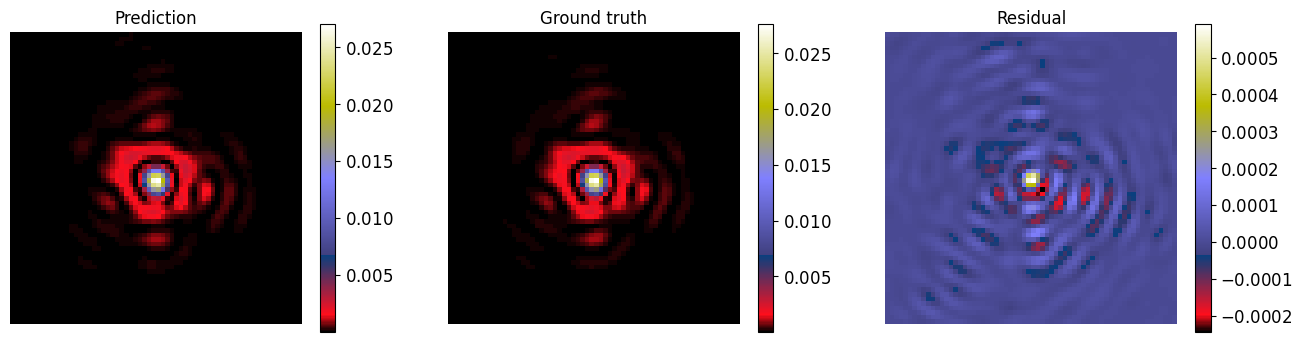

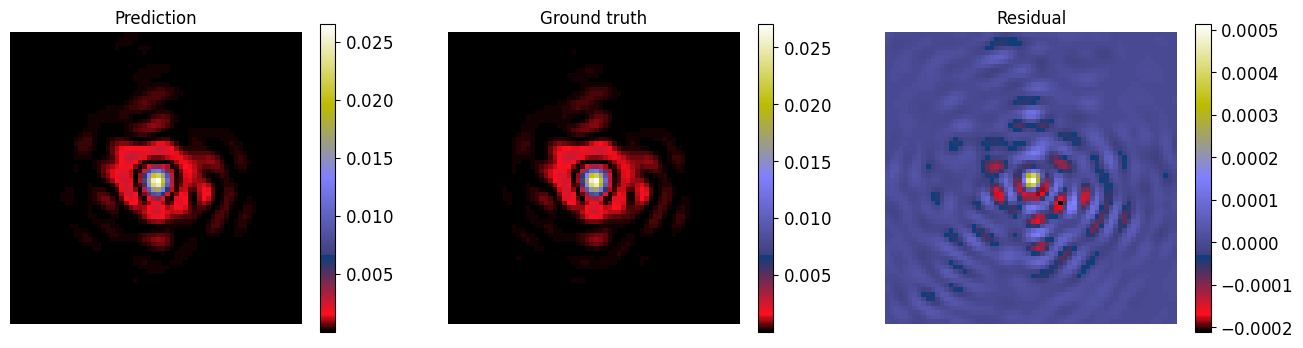

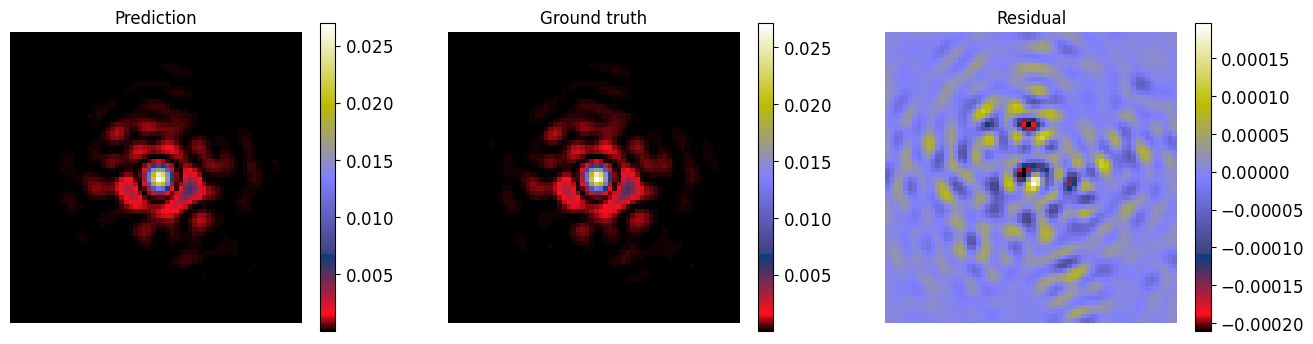

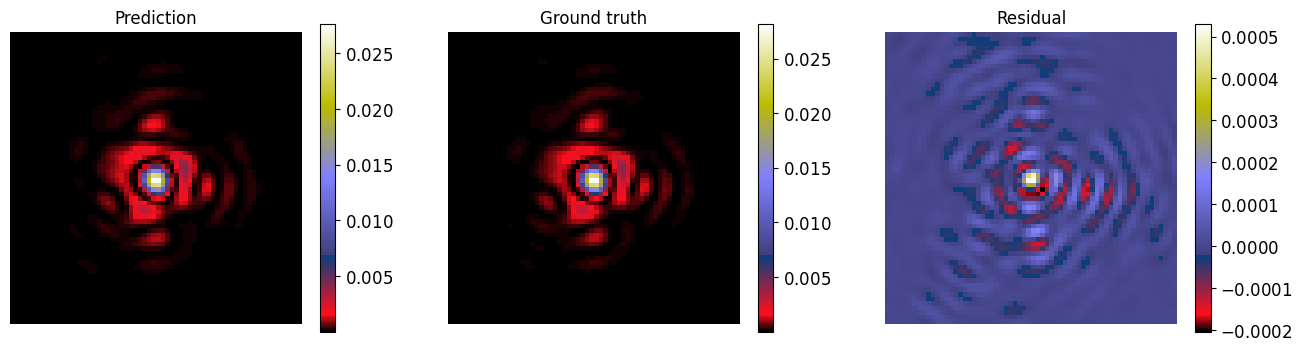

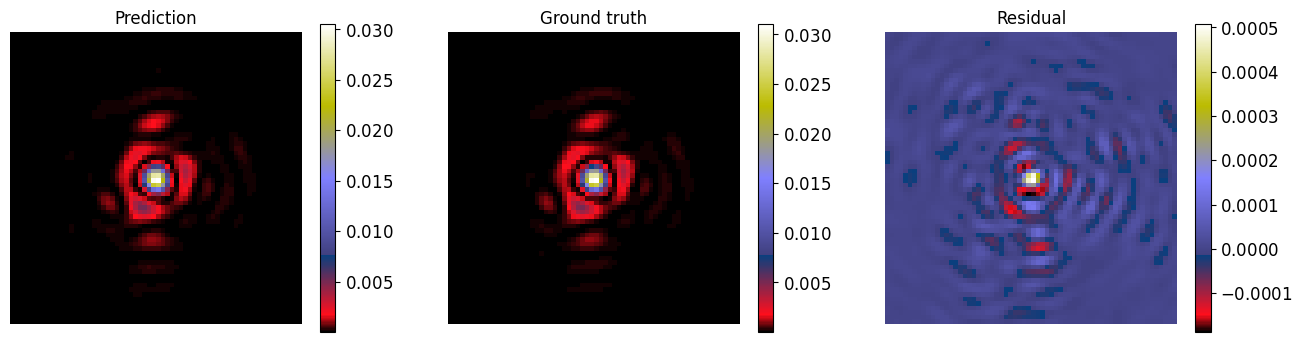

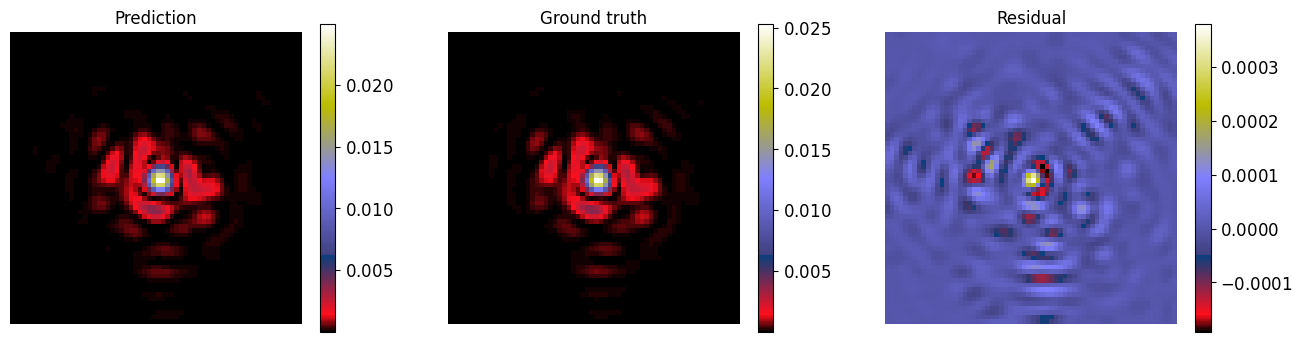

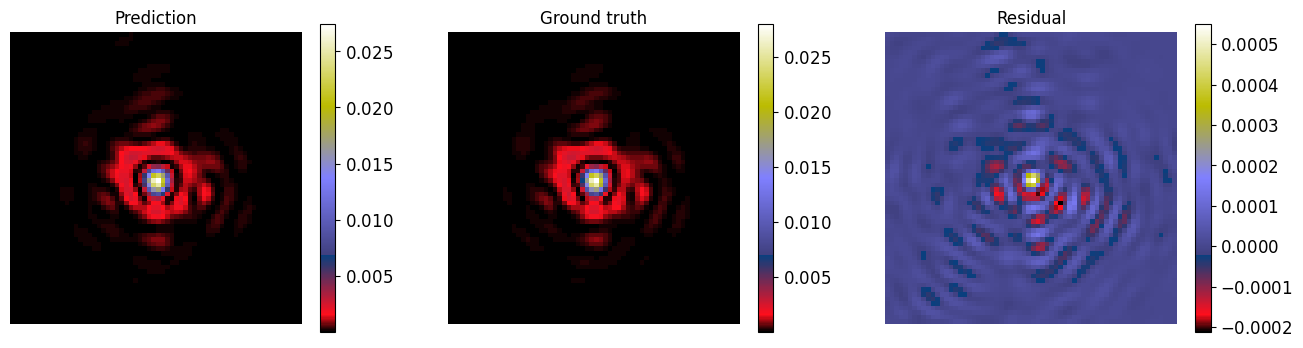

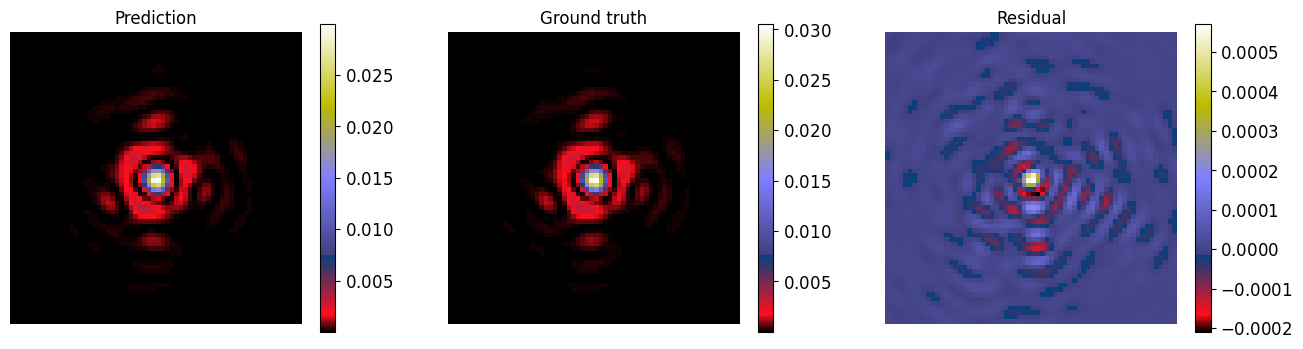

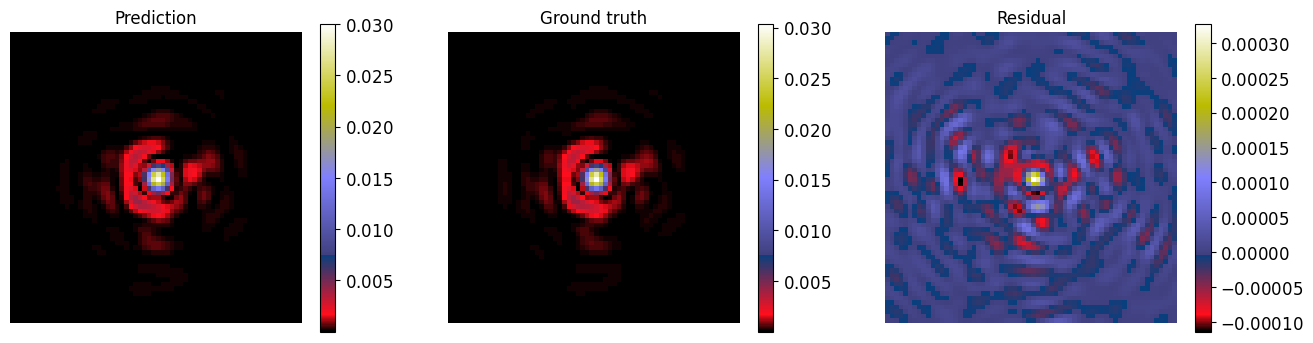

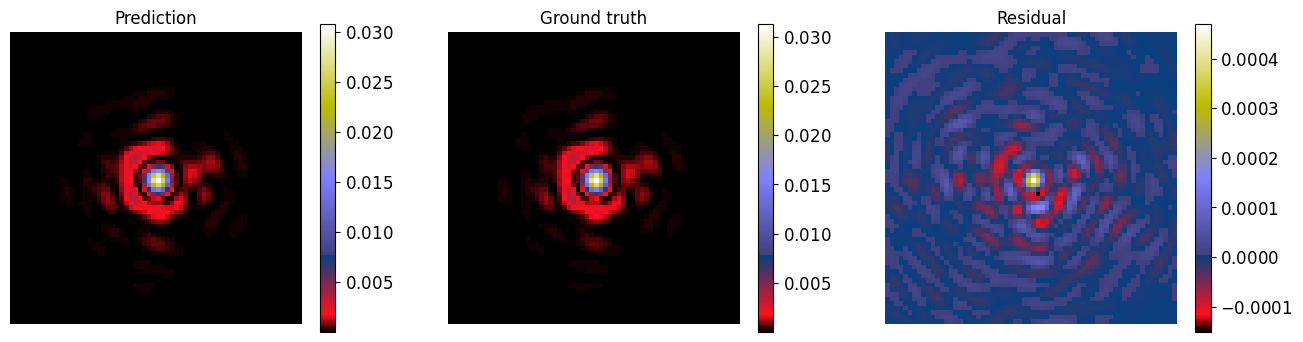

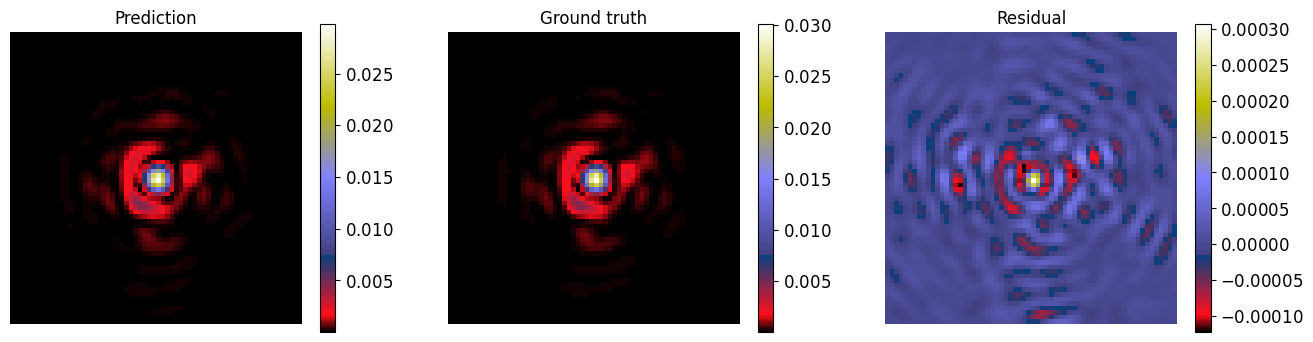

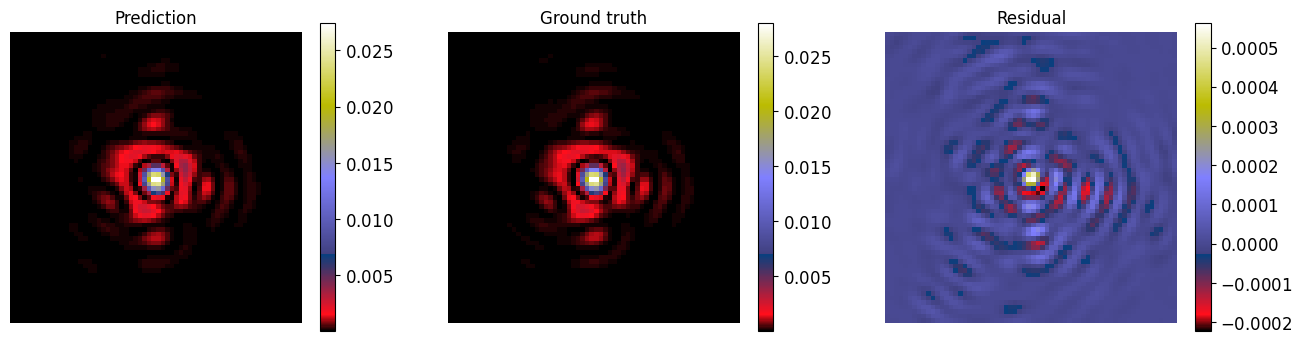

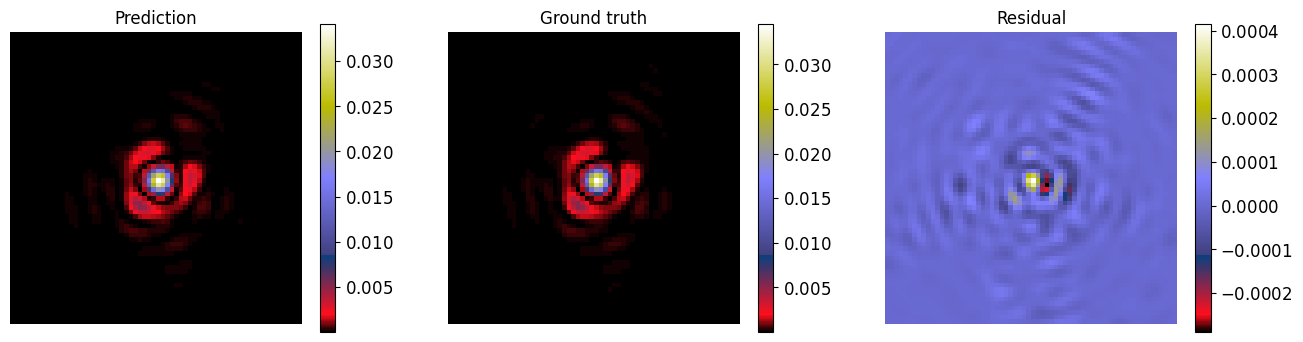

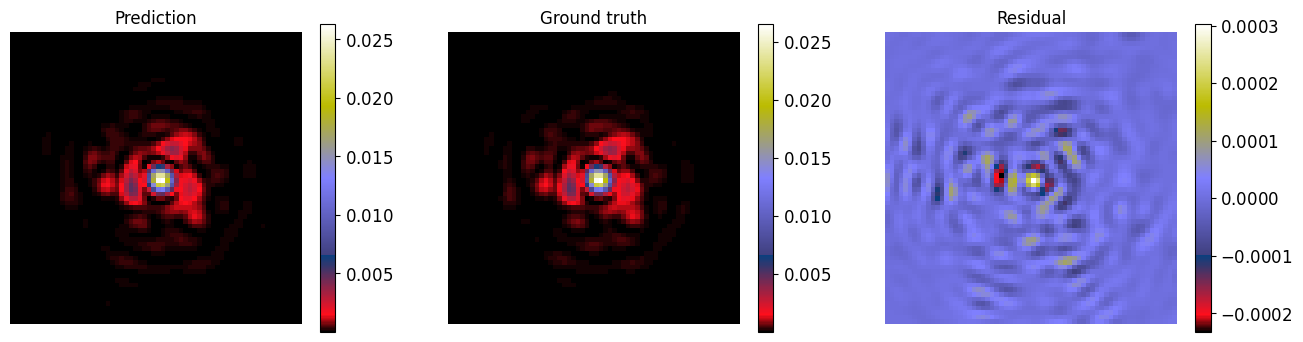

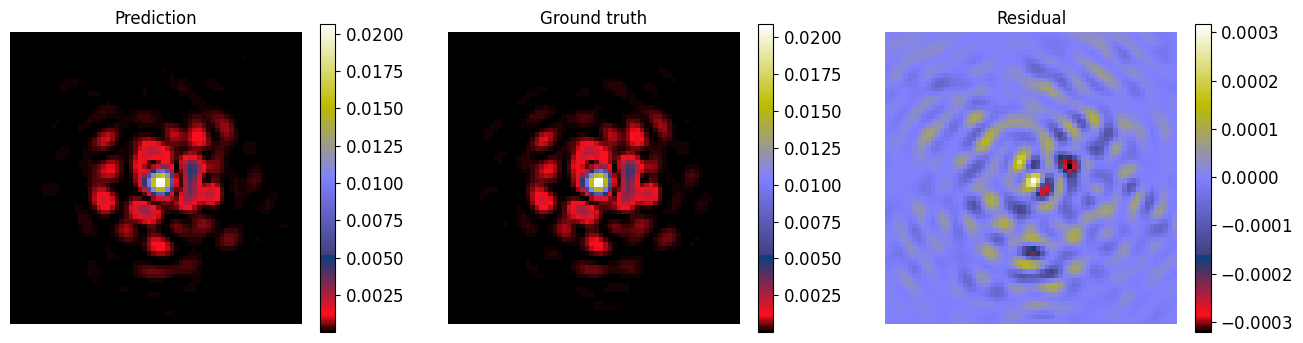

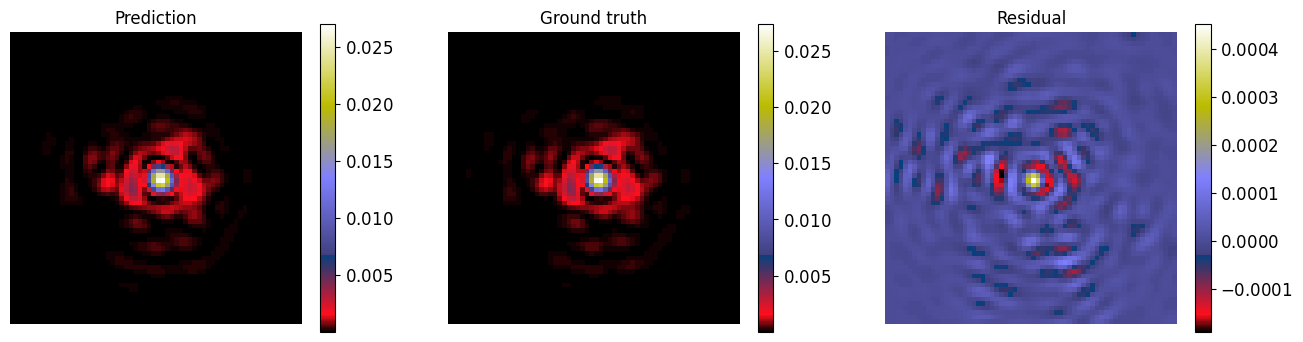

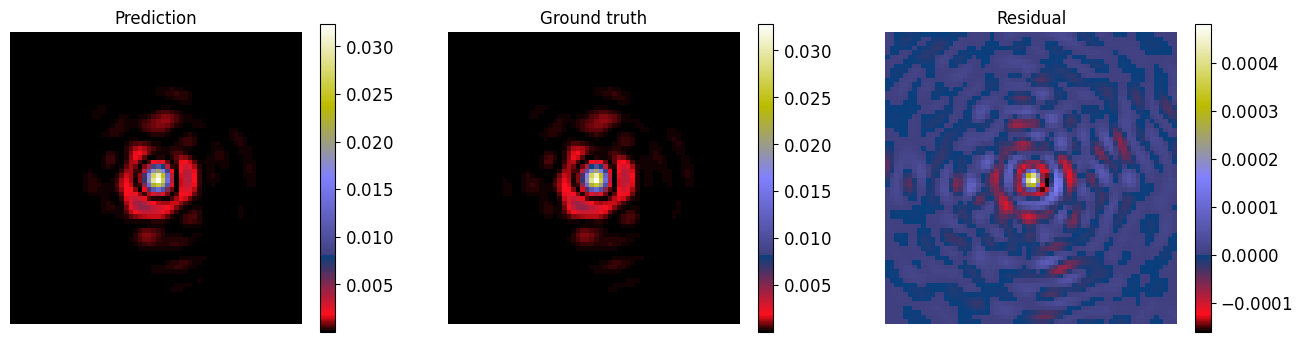

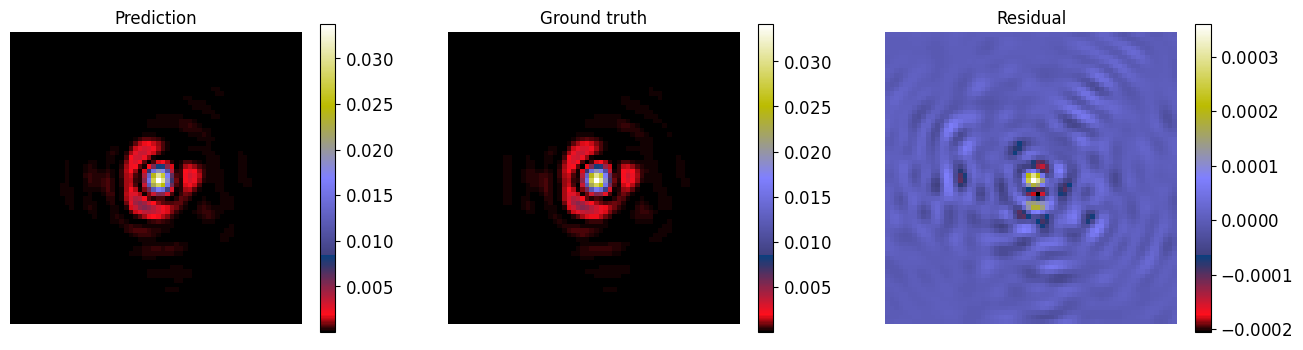

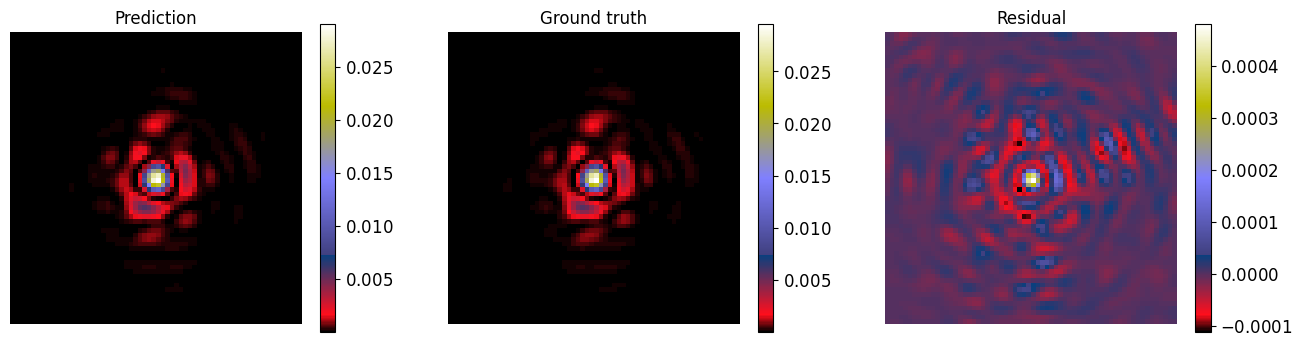

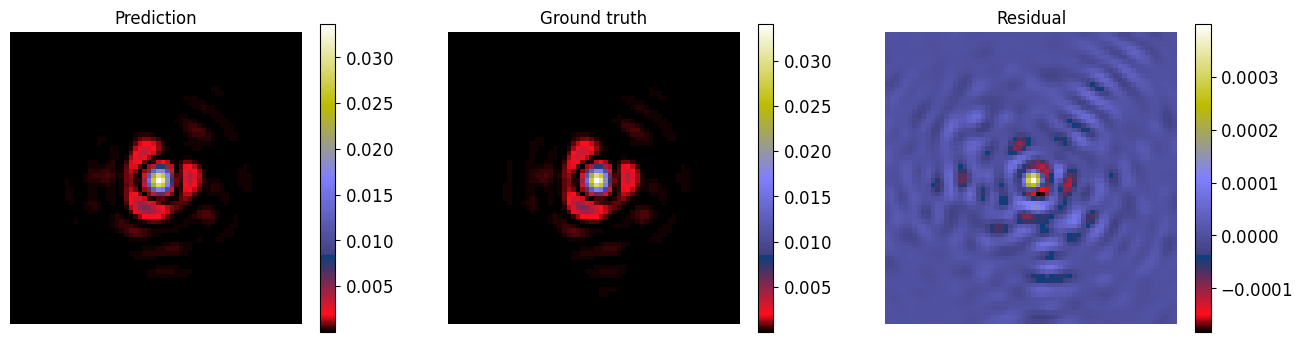

In [57]:


for it in range(20):
    fig, ax = plt.subplots(1, 3, figsize=(16,4))
    im = ax[0].imshow(debug_psfs[it,:,:], cmap='gist_stern')
    ax[0].set_title('Prediction')
    plt.colorbar(im, ax=ax[0])

    im = ax[1].imshow(debug_GT_psfs[it,:,:], cmap='gist_stern')
    ax[1].set_title('Ground truth')
    plt.colorbar(im, ax=ax[1])

    im = ax[2].imshow(debug_GT_psfs[it,:,:] - debug_psfs[it,:,:], cmap='gist_stern')
    ax[2].set_title('Residual')
    plt.colorbar(im, ax=ax[2])

    for j in range(3):
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].spines['top'].set_visible(False)
        ax[j].spines['right'].set_visible(False)
        ax[j].spines['bottom'].set_visible(False)
        ax[j].spines['left'].set_visible(False)

    plt.show()